In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy as bce
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

### Load dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Model

In [3]:
batch_size = 100
original_dim = 28 * 28
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape = (batch_size, latent_dim), mean = 0., stddev = epsilon_std)
    return z_mean + tf.math.exp(z_log_var / 2) * epsilon

In [5]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [6]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [7]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (100, 2)]                          
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


### Training

In [8]:
xent_loss = original_dim * bce(reduction=tf.keras.losses.Reduction.NONE)(x, output_combined)
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis = -1)
vae.add_loss(xent_loss)
vae.add_loss(kl_loss)
vae.compile(optimizer = 'rmsprop')
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 5s 6ms/step - loss: 191.0634
Epoch 2/50
600/600 [==============================] - 4s 6ms/step - loss: 170.1194
Epoch 3/50
600/600 [==============================] - 5s 7ms/step - loss: 166.9193
Epoch 4/50
600/600 [==============================] - 5s 8ms/step - loss: 164.8197
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 163.3063
Epoch 6/50
600/600 [==============================] - 5s 8ms/step - loss: 162.0338
Epoch 7/50
600/600 [==============================] - 4s 7ms/step - loss: 160.8959
Epoch 8/50
600/600 [==============================] - 4s 7ms/step - loss: 159.8089
Epoch 9/50
600/600 [==============================] - 4s 7ms/step - loss: 158.8671
Epoch 10/50
600/600 [==============================] - 4s 7ms/step - loss: 158.0506
Epoch 11/50
600/600 [==============================] - 4s 6ms/step - loss: 157.3777
Epoch 12/50
600/600 [==============================] - 4s 6ms/step - loss: 156.7711
E

### Predictions

100/100 [==============================] - 0s 2ms/step


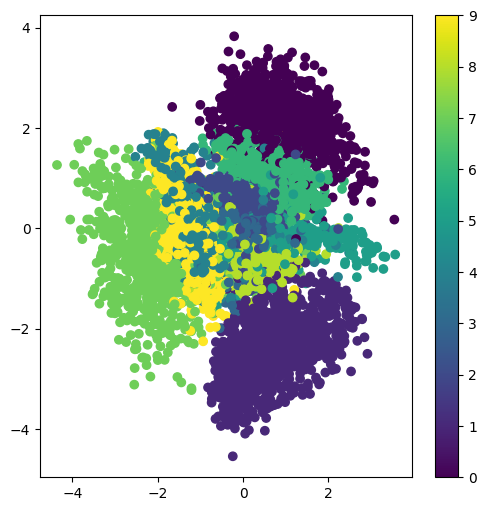

In [9]:
x_test_encoded = encoder.predict(x_test, batch_size = batch_size)[0]
plt.figure(figsize = (6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c = y_test, cmap='viridis')
plt.colorbar()
plt.show()

### Generating figures

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [00:16<00:00, 13.62it/s]


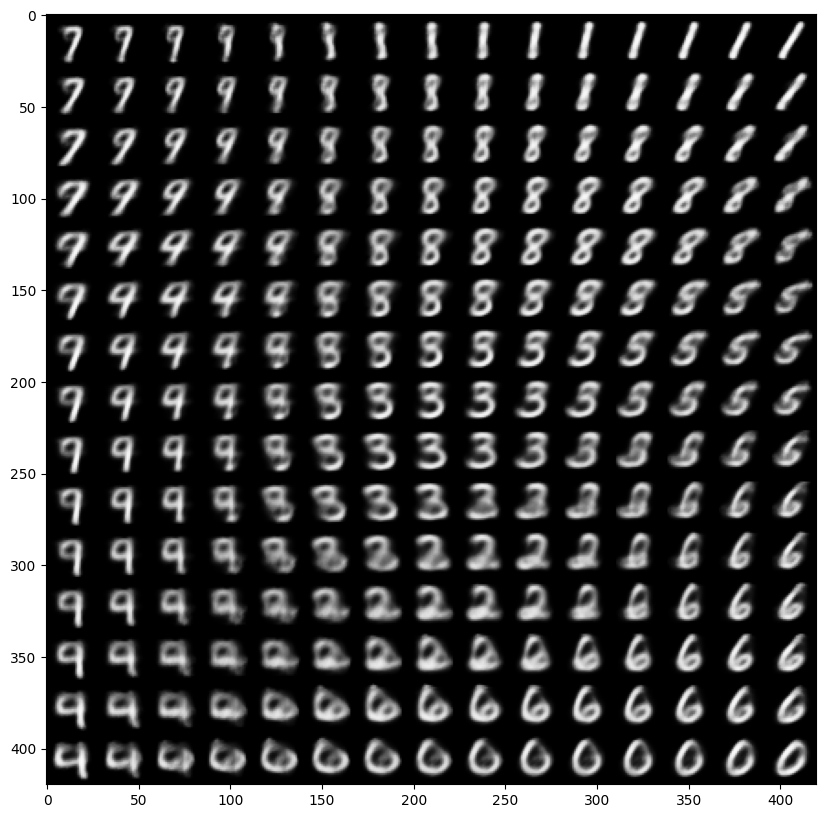

In [10]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

with tqdm(total=len(grid_x) * len(grid_y)) as pbar:
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample, verbose = 0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            pbar.update(1)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()